In [1]:
import numpy as np
import torch
import torchvision
import torch.nn as nn
import matplotlib.pyplot as plt
from PIL import Image
import os
import torch.nn.functional as F

from src.utils.config import RESNET34_FULL,BEETLE_DATASET, Config, DEFAULT_TEST_PATH
from src.models import download_model, load_model_weights_and_metrics, GenModel

In [2]:
class G_block(nn.Module):
    def __init__(self, out_channels, in_channels=3, kernel_size=(4,4), strides=(2,2),
                 padding=(1,1), **kwargs):
        super(G_block, self).__init__(**kwargs)
        self.conv2d_trans = nn.ConvTranspose2d(in_channels, out_channels,
                                kernel_size, strides, padding, bias=False)
        self.batch_norm = nn.BatchNorm2d(out_channels)
        self.activation = nn.ReLU()

    def forward(self, X):
        return self.activation(self.batch_norm(self.conv2d_trans(X)))

In [3]:
n_G = 64
net_G = nn.Sequential(
    G_block(in_channels=197, out_channels=n_G*16, kernel_size=(7,14),
            strides=1, padding=0),                  # Output: (64 * 16, 7, 14)
    G_block(in_channels=n_G*16, out_channels=n_G*8), # Output: (64 * 8, 14, 28)
    G_block(in_channels=n_G*8, out_channels=n_G*4), # Output: (64 * 4, 28, 56)
    G_block(in_channels=n_G*4, out_channels=n_G*2), # Output: (64 * 2, 56, 112)
    G_block(in_channels=n_G*2, out_channels=n_G),   # Output: (64, 112, 224)
    nn.ConvTranspose2d(in_channels=n_G, out_channels=3,
                       kernel_size=4, stride=2, padding=1, bias=False),
    nn.Tanh())  # Output: (3, 224, 448)

In [4]:
file_path = DEFAULT_TEST_PATH
stat_files = []
gen_files = []
for file in os.listdir(file_path):
    if file.endswith(".pt"):
        gen_files.append(os.path.join(file_path, file))
    if file.endswith(".npy"):
        stat_files.append(os.path.join(file_path, file))

In [5]:
def visual_insection():

    class_0_file = 'data/beetles/images/achenium_humile/_0189_0.jpg'
    class_21_file = 'data/beetles/images/emus_hirtus/_0486_5.jpg'
    class_48_file = 'data/beetles/images/lathrobium_fulvipenne/_0149_5.jpg'
    class_94_file = 'data/beetles/images/philonthus_concinnus/_0370_3.jpg'
    class_153_file = 'data/beetles/images/quedius_maurorufus/_0541_21.jpg'

    class_0_img = Image.open(class_0_file)
    class_21_img = Image.open(class_21_file)
    class_48_img = Image.open(class_48_file)
    class_94_img = Image.open(class_94_file)
    class_153_img = Image.open(class_153_file)

    images = [class_0_img, class_21_img, class_48_img, class_94_img, class_153_img]

    if use_latent:
        transformation = torchvision.transforms.Compose([
            torchvision.transforms.Resize((224, 448)),
            torchvision.transforms.ToTensor(),
            torchvision.transforms.Normalize(config.mean, config.std)])

        tensor_list = [transformation(img) for img in images]

        tensors = torch.stack(tensor_list).to('cuda')

        latent_code = model(tensors).reshape(5,197,1,1)
    else:

        latent_code = F.one_hot(torch.tensor([0,21,48,94,153]), 197).float()
        latent_code = latent_code.reshape((-1, 197, 1,1)).to('cuda')

    gen_imgs = net_G(latent_code).cpu().detach().numpy().transpose(0,2,3,1)
    gen_imgs = (gen_imgs+1)/2

    fig, ax = plt.subplots(5,2,figsize=(20,30))
    fig.set_facecolor('white')

    ax[0,0].imshow(class_0_img)
    ax[0,0].axis('off')
    ax[0,0].set_title('Dataset class 0')
    ax[1,0].imshow(class_21_img)
    ax[1,0].axis('off')
    ax[1,0].set_title('Dataset class 21')
    ax[2,0].imshow(class_48_img)
    ax[2,0].axis('off')
    ax[2,0].set_title('Dataset class 48')
    ax[3,0].imshow(class_94_img)
    ax[3,0].axis('off')
    ax[3,0].set_title('Dataset class 94')
    ax[4,0].imshow(class_153_img)
    ax[4,0].axis('off')
    ax[4,0].set_title('Dataset class 153')

    ax[0,1].imshow(gen_imgs[0])
    ax[0,1].axis('off')
    ax[0,1].set_title('Generated class 0')
    ax[1,1].imshow(gen_imgs[1])
    ax[1,1].axis('off')
    ax[1,1].set_title('Generated class 21')
    ax[2,1].imshow(gen_imgs[2])
    ax[2,1].axis('off')
    ax[2,1].set_title('Generated class 48')
    ax[3,1].imshow(gen_imgs[3])
    ax[3,1].axis('off')
    ax[3,1].set_title('Generated class 94')
    ax[4,1].imshow(gen_imgs[4])
    ax[4,1].axis('off')
    ax[4,1].set_title('Generated class 153')


    plt.tight_layout

In [6]:
def compare_stats():
    stats_all = []
    for i in range(len(stat_files)):
        temp = np.load(stat_files[i])
        stats_all.append(temp)

    fig, ax = plt.subplots(1,1,figsize=(20,10))
    fig.set_facecolor('white')

    for i in range(len(stats_all)):
        ax.plot(stats_all[i][3], label=stat_files[i][15:-4])

    ax.set_ylabel('feature loss')
    ax.set_xlabel('epoch')
    ax.legend()
    ax.grid()

In [7]:
def gauss(x, mean, std):
    exp = (x- mean)**2 / (2*std**2)
    return torch.exp(-exp)

def gen_input(start, end, step_size, std=0.25):
    r = int(end-start)
    l = int(r/step_size) - int(1/step_size) + 1
    ret = torch.zeros((  l, r))
    for i in range(l):
        x = torch.linspace(start, end-1, r)
        ret[i] = gauss(x, start + step_size*i, std)

    return ret.reshape(ret.shape[0],ret.shape[1], 1,1)

In [8]:
def walk(X, gen, model, batch_size, device='cuda'):
    ret = np.zeros(X.shape[0])
    l = int(X.shape[0] // batch_size)


    m = torch.tensor(config.mean)
    s = torch.tensor(config.std)
    mean_tensor = torch.zeros(3,224,448)
    std_tensor = torch.zeros(3,224,448)
    mean_tensor[0,:] = m[0]   
    mean_tensor[1,:] = m[1] 
    mean_tensor[2,:] = m[2] 

    std_tensor[0,:] = s[0]   
    std_tensor[1,:] = s[1] 
    std_tensor[2,:] = s[2] 
    mean = mean_tensor.to(device)
    std = std_tensor.to(device)

    for i in range(l+1):
        if i % 100 == 0:
            print(f'{i} of {l}')
        batch = X[i*batch_size:(i+1)*batch_size]
        batch = batch.to(device)

        img = (gen(batch) - mean)/std
        res = model(img).cpu().detach().numpy()
        ret[i*batch_size:(i+1)*batch_size] = np.argmax(res, 1)

    return ret

In [9]:
def linear_walk():
    start = 0
    end = 197
    step_size = 1
    batch_size=32
    correction = int(1/step_size)-1
    l = int((end-start)/step_size)

    res_x = np.linspace(start,end-1, l-correction)

    linwalk_x = gen_input(start,end,step_size)

    linwalk = walk(linwalk_x, net_G, model, batch_size)

    fig, ax = plt.subplots(1,1,figsize=(30,10))
    fig.set_facecolor('white')
    ax.plot([0,196],[0,196], c='r')
    ax.scatter(res_x, linwalk)
    ax.set_ylabel('Class')
    ax.set_xlabel('Point on vector')
    ax.grid()

    print(np.sum(res_x == linwalk)/196)

In [10]:
def compare_stats():
    stats_all = []
    for i in range(len(stat_files)):
        temp = np.load(stat_files[i])
        stats_all.append(temp)

    fig, ax = plt.subplots(1,1,figsize=(20,10))
    fig.set_facecolor('white')

    for i in range(len(stats_all)):
        ax.plot(stats_all[i][3], label=stat_files[i][15:-4])

    ax.set_ylabel('feature loss')
    ax.set_xlabel('epoch')
    ax.legend()
    ax.grid()


In [11]:
model_config = RESNET34_FULL
dataset_config =BEETLE_DATASET

config = Config()

model = download_model(model_config, dataset_config)
_, _, _, _ = load_model_weights_and_metrics(model, model_config)
model = model.eval().to('cuda')

In [12]:
gen_files

['./output/tests/test_subset_gen.pt',
 './output/tests/lambdas_feat_gen.pt',
 './output/tests/test_gen.pt',
 './output/tests/lambdas_adv_gen.pt',
 './output/tests/lambdas_equal_gen.pt',
 './output/tests/lambdas_img_gen.pt']

In [13]:
gen_nr = 2

use_latent = True

In [14]:
specific_gen = gen_files[gen_nr]
net_G.load_state_dict(torch.load(specific_gen))
net_G = net_G.to('cuda')

# Visual inspection

/home/thorreign/anaconda3/lib/python3.8/site-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /opt/conda/conda-bld/pytorch_1623448278899/work/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


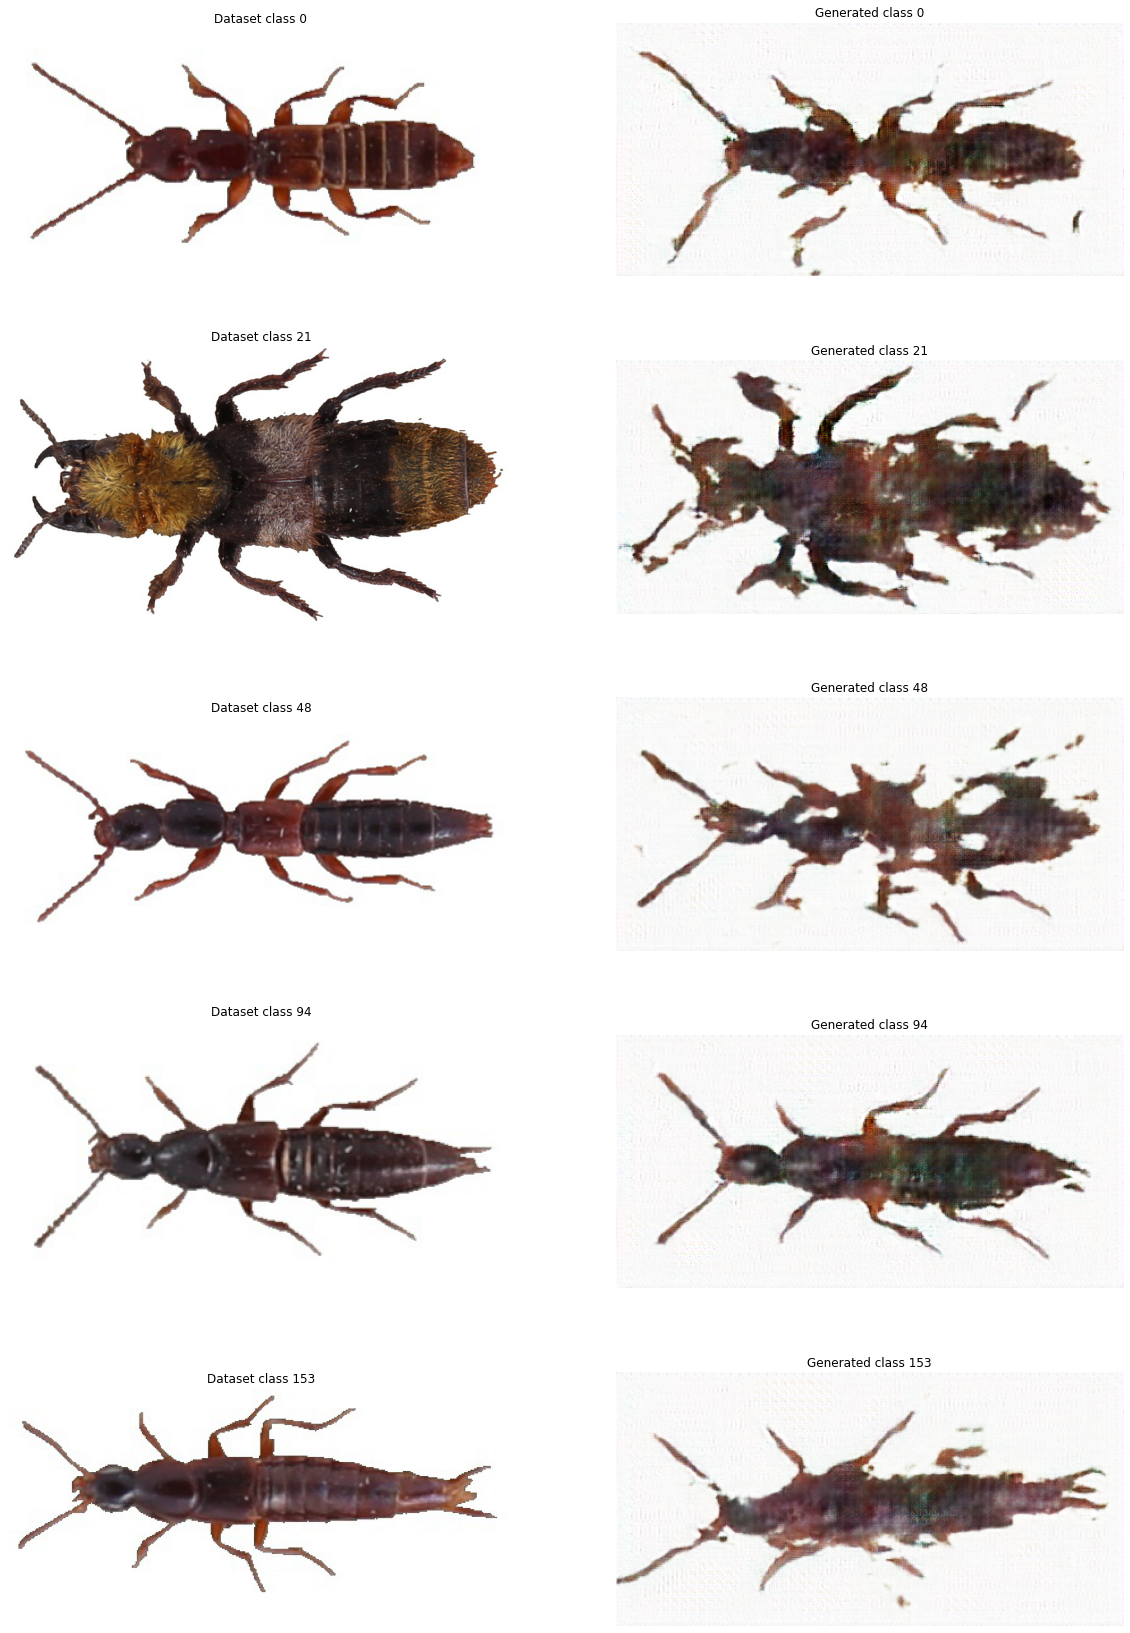

In [15]:
visual_insection()

# Compare input structure

0 of 6
0.00510204081632653


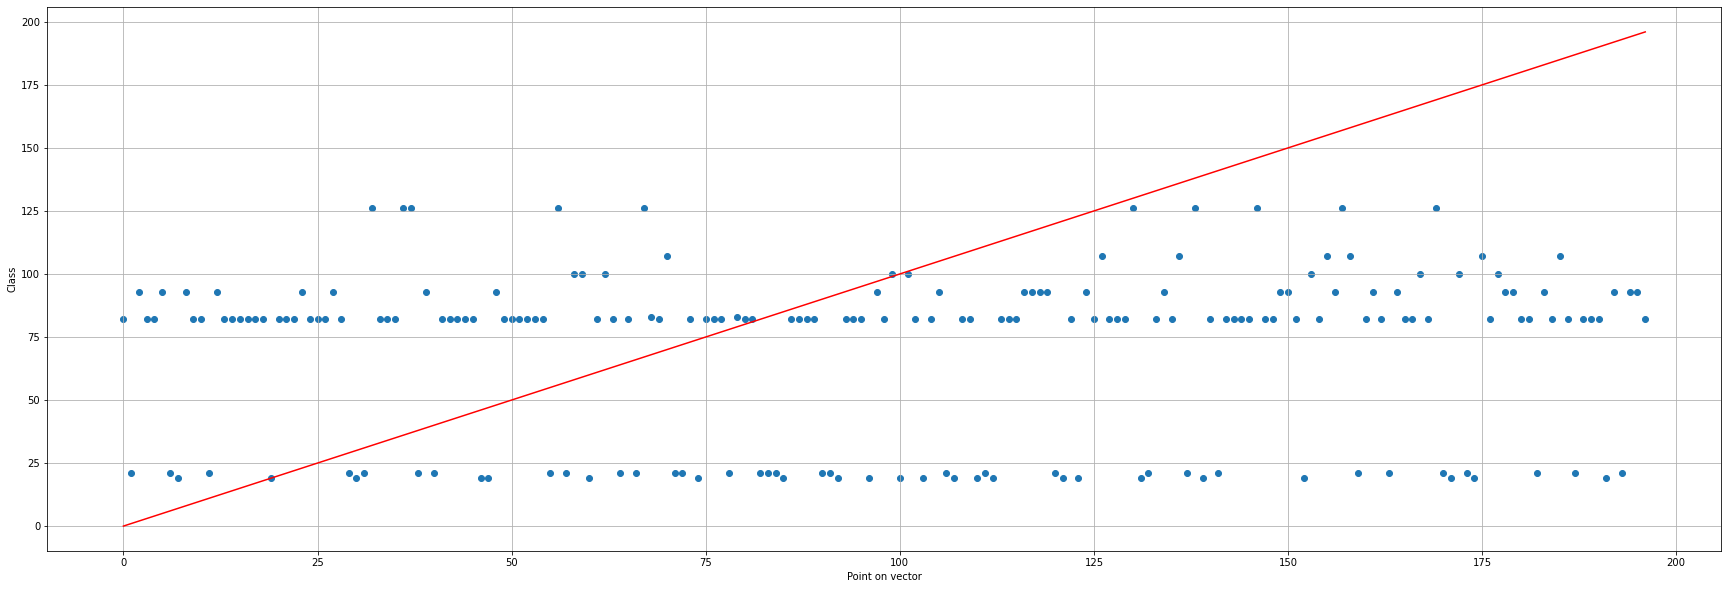

In [16]:
linear_walk()

# Compare feature loss of all generators

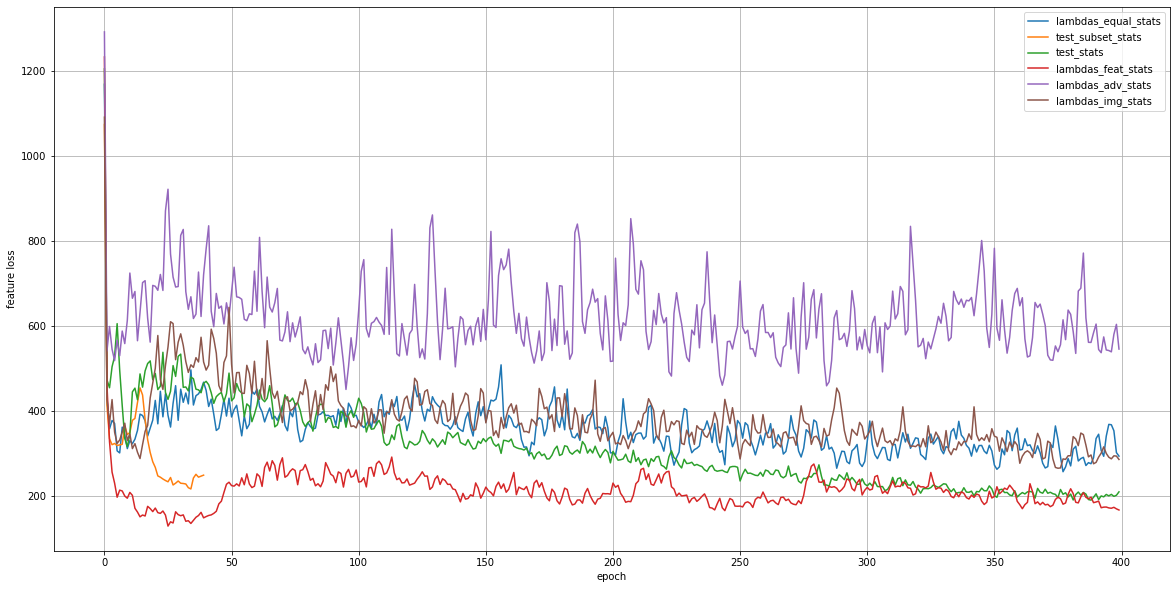

In [17]:
compare_stats()